In [83]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import basemodel, non_norm, ResnetLayer, Resnet, Resnet_regression
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import scipy.signal as signal
from scipy.ndimage import gaussian_filter1d

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

In [17]:
def low_pass_filter(x, cutoff_frequency, sample_rate, order=1):
  """
  Args:
    x: 입력 데이터
    cutoff_frequency: 차단 주파수
    sample_rate: 샘플링 주파수
    order: 필터 차수

  Returns:
    필터링된 데이터
  """

  # 버터워스 필터 설정
  b, a = signal.butter(order, cutoff_frequency / (sample_rate / 2), btype='lowpass')

  # 필터 적용
  y = signal.filtfilt(b, a, x)

  return y

In [2]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [3]:
def file_sort(path):
    file_list = os.listdir(path)
    for file in file_list:
        if os.path.isfile(os.path.join(path, file)):
            createFolder('./'+path+'/' + file[:2])
            shutil.move('./'+path+'/' + file, './'+path+'/' + file[:2] + '/' + file)

In [4]:
def file_load(path):
    # data = list()
    file_list = sorted(os.listdir(path))
    data = None
    for file in file_list:
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            try:
                temp = np.load(file_path)
                if data is not None:
                    data = np.concatenate((data, temp), axis = 0)
                else:
                    data = temp
            except:
                print('Error')
                print(file)
            # data.append(temp)
    return np.squeeze(data, axis = 1)

In [5]:
def file_load_list(path):
    # data = list()
    file_list = sorted(os.listdir(path))
    data = None
    for file in file_list:
        arr = list()
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            print(file_path)
            try:
                arr.append(np.load(file_path))
            except:
                print('Error')
                print(file)
            # data.append(temp)
    return arr

In [42]:
folder_path = 'sampled_data_same_cycle'
# folder_path = 'counting_disk'
# folder_path = 'counting'

In [43]:
file_sort(folder_path)

In [44]:
folder_list = os.listdir(folder_path)

In [45]:
folder_list = sorted(folder_list)

In [46]:
temp_path = os.path.join(folder_path,folder_list[1])
data = file_load(temp_path)

In [47]:
data_dict = dict()
for folder in folder_list:
    temp_path = os.path.join(folder_path,folder)
    data_dict[folder] = np.array(file_load(temp_path))

In [48]:
list_dict = dict()
for folder in folder_list:
    temp_path = os.path.join(folder_path,folder)
    list_dict[folder] = {}
    file_list = sorted(os.listdir(temp_path))
    for file in file_list:
        file_path = os.path.join(temp_path,file)
        if os.path.isfile(file_path):
            # print(file_path)
            try:
                list_dict[folder][file] = np.squeeze(np.load(file_path), axis = 1)
            except:
                print('Error')
                print(file)

In [53]:
initial_dict = dict()
for i in list_dict['00'].keys():
    temp_key = i.split('_')[1]
    print(i)
    print(temp_key)
    initial_dict[temp_key] = np.expand_dims(np.mean(list_dict['00'][i], axis = 0), axis = 0)

00_0.npy
0.npy
00_1.npy
1.npy
00_2.npy
2.npy
00_3.npy
3.npy


In [64]:
initial_dict['0.npy'].shape

(1, 301)

In [71]:
list_dict['00'].keys()

dict_keys(['00_0.npy', '00_1.npy', '00_2.npy', '00_3.npy'])

In [77]:
list_dict['00'].keys()

dict_keys(['00_0.npy', '00_1.npy', '00_2.npy', '00_3.npy'])

In [81]:
sub_dict = dict()
for i in list_dict:
    sub_dict[i] = dict()
    for j in list_dict[i]:
        temp_key = j.split('_')[1]
        sub_dict[i][j] = np.subtract(list_dict[i][j],initial_dict[temp_key])
        

00_0.npy
0.npy
00_1.npy
1.npy
00_2.npy
2.npy
00_3.npy
3.npy
01_0.npy
0.npy
01_1.npy
1.npy
01_2.npy
2.npy
01_3.npy
3.npy


8


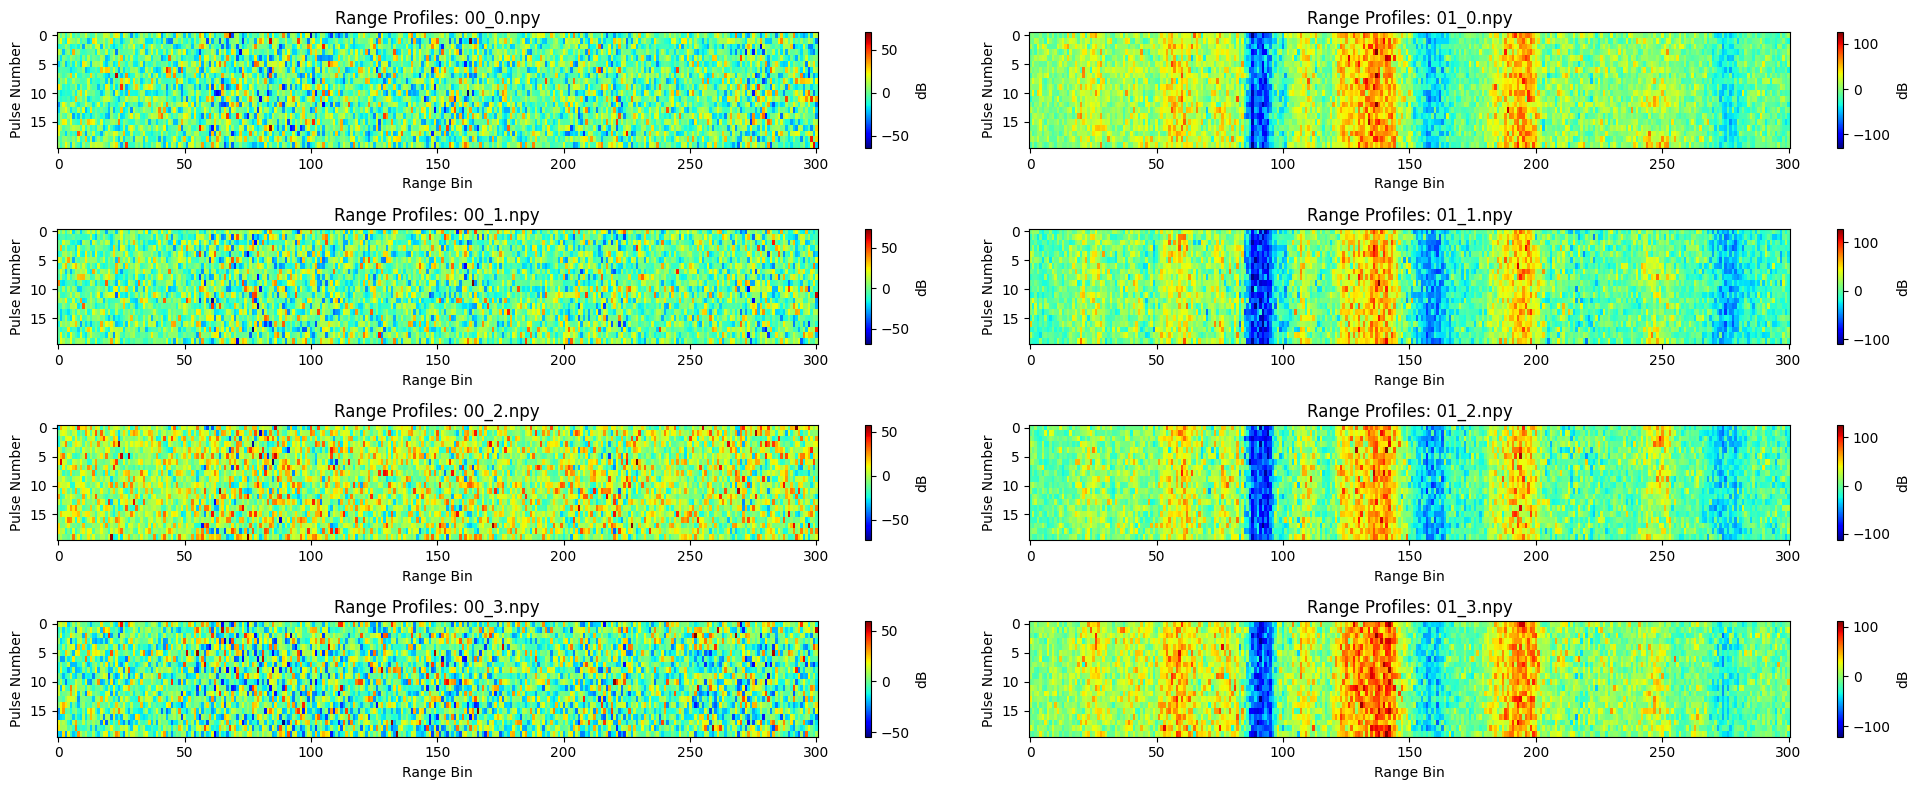

In [82]:
subplot(sub_dict)

In [84]:
gf_sub_dict = dict()
for i in sub_dict:
    gf_sub_dict[i] = dict()
    for j in sub_dict[i]:
        gf_sub_dict[i][j] = gaussian_filter1d(sub_dict[i][j], 1)

8


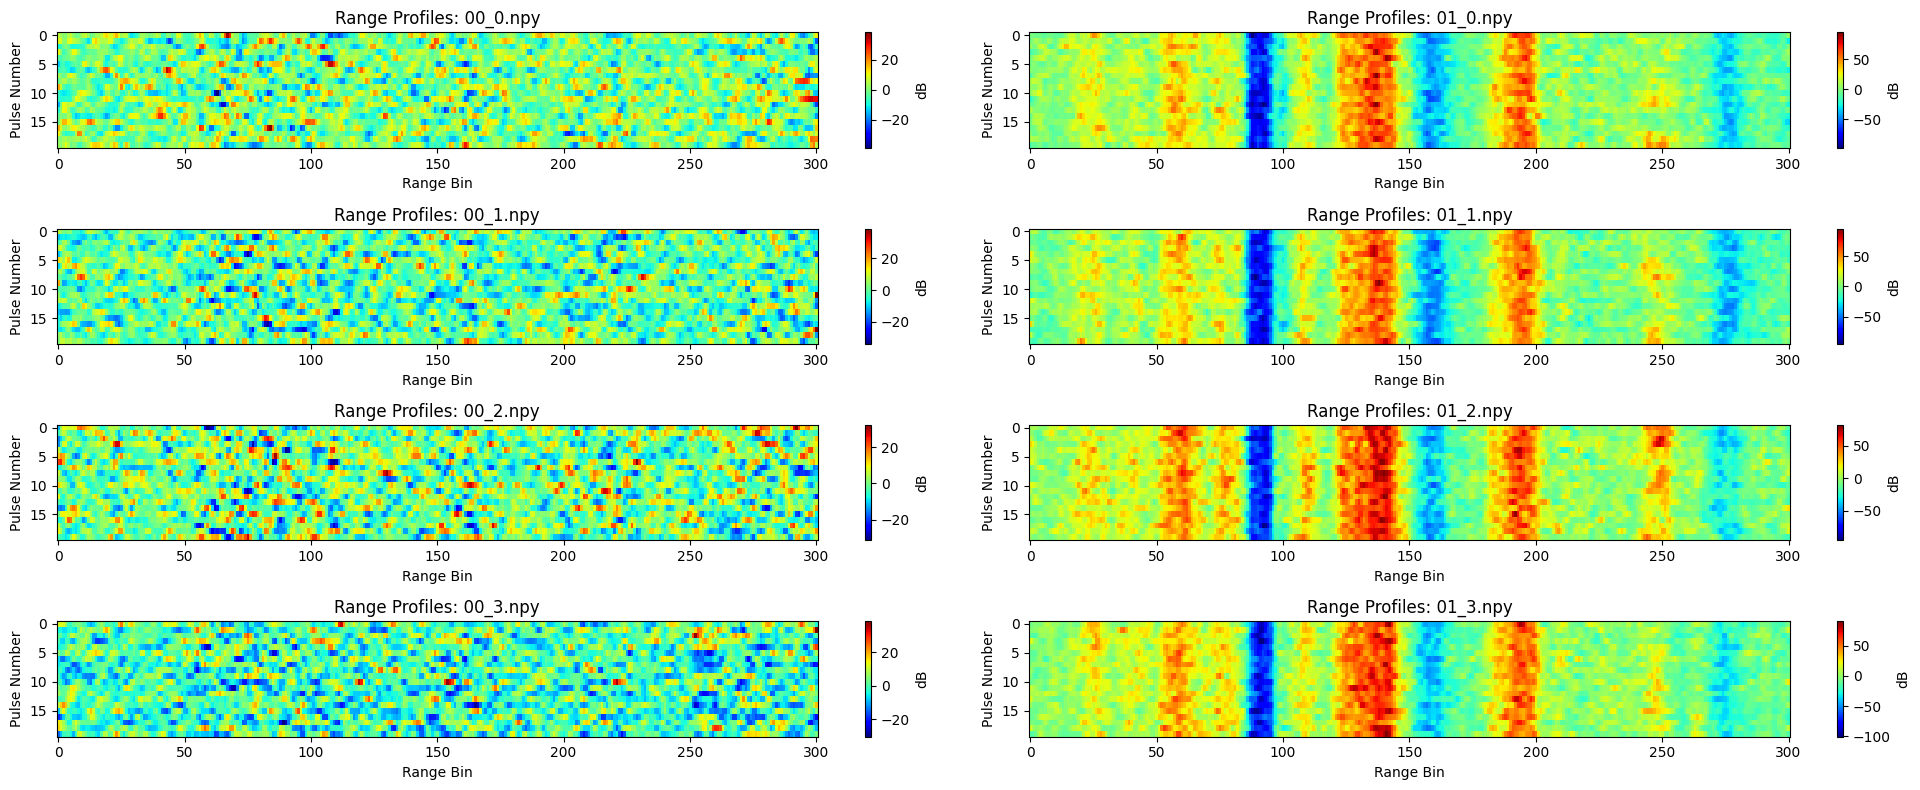

In [85]:
subplot(gf_sub_dict)

In [19]:
list_dict['01'].keys()

dict_keys(['1_0_0.npy', '1_0_1.npy', '1_0_2.npy', '1_0_3.npy', '1_0_4.npy', '1_1_0.npy', '1_1_1.npy', '1_1_2.npy', '1_1_3.npy', '1_1_4.npy', '1_2_0.npy', '1_2_1.npy', '1_2_2.npy', '1_2_3.npy', '1_2_4.npy'])

In [28]:
def subplot(data_dict):
    # 서브플롯 그리기
    num_profiles = 0
    maximum = 0
    for i in data_dict:
        num_profiles += len(data_dict[i])
        maximum = np.max((len(data_dict[i]), maximum))
    # num_profiles = len(data_dict)
    print(num_profiles)
    plt.figure(figsize=(maximum * 5, num_profiles))

    for col, (key,profile) in enumerate(data_dict.items(), 1):
        for idx, (key2, profile2) in enumerate(profile.items(), 1):
            plt_idx = col + len(data_dict) * (idx - 1)
            # if col == 1:
            #     plt_idx = 2 * idx - 1
            # else:
            #     plt_idx = 2 * idx
            r, c, p = int(maximum), len(data_dict), plt_idx
            plt.subplot(r, c, p)
            plt.imshow(profile2, aspect='auto', cmap='jet', interpolation='none')
            # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
            plt.colorbar(label="dB")
            plt.xlabel("Range Bin")
            plt.ylabel("Pulse Number")
            plt.title(f"Range Profiles: {key2}")

    plt.tight_layout()
    plt.show()

In [26]:
# 서브플롯 그리기
num_profiles = 0
maximum = 0
for i in list_dict:
    num_profiles += len(list_dict[i])
    maximum = np.max((len(list_dict[i]), maximum))
# num_profiles = len(data_dict)
print(num_profiles)
plt.figure(figsize=(maximum * 5, num_profiles))

for col, (key,profile) in enumerate(list_dict.items(), 1):
    for idx, (key2, profile2) in enumerate(profile.items(), 1):
        plt_idx = col + len(list_dict) * (idx - 1)
        # if col == 1:
        #     plt_idx = 2 * idx - 1
        # else:
        #     plt_idx = 2 * idx
        r, c, p = int(maximum), len(list_dict), plt_idx
        plt.subplot(r, c, p)
        plt.imshow(profile2, aspect='auto', cmap='jet', interpolation='none')
        # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
        plt.colorbar(label="dB")
        plt.xlabel("Range Bin")
        plt.ylabel("Pulse Number")
        plt.title(f"Range Profiles: {key2}")

plt.tight_layout()
plt.show()

70


In [37]:
filter_dict = dict()
for i in list_dict:
    filter_dict[i] = dict()
    for j in list_dict[i]:
        filter_dict[i][j] = list()
        for k in range(len(list_dict[i][j])):
            filter_dict[i][j].append(low_pass_filter(list_dict[i][j][k], 100, 1000, 1))

In [38]:
subplot(filter_dict)

70


In [40]:

gaussian_filter_dict = dict()
for i in list_dict:
    gaussian_filter_dict[i] = dict()
    for j in list_dict[i]:
        gaussian_filter_dict[i][j] = list()
        for k in range(len(list_dict[i][j])):
            gaussian_filter_dict[i][j].append(gaussian_filter1d(list_dict[i][j][k], sigma=1))

In [41]:
subplot(gaussian_filter_dict)

70
